In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans,KMeans,SpectralClustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("data_for_test.csv")

### delete mean_hr in the train_set which number is zero

In [3]:
train.head()

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,xx1,xx2,xx3,xx4,xx5,y_mean_MAP,y_mean_HR
0,1891,1891-3,1,75,22,1,2,0,0,1,80.0,95.0,99.9,49.4,62.5,59.04,80.0
1,1891,1891-3,1,75,22,1,2,0,0,1,80.0,94.9,98.4,48.7,61.3,59.04,80.0
2,1891,1891-3,1,75,22,1,2,0,0,1,80.0,95.0,95.3,48.5,60.3,59.04,80.0
3,1891,1891-3,1,75,22,1,2,0,0,1,80.0,95.0,97.4,48.9,61.3,59.04,80.0
4,1891,1891-3,1,75,22,1,2,0,0,1,76.7,95.7,99.6,50.2,62.8,59.04,80.0


In [5]:
train.groupby('y_mean_HR')[['patient_id']].count()
train.groupby('y_mean_MAP')[['patient_id']].count()

,patient_id
y_mean_HR,
0.000000,780
3.160000,30
13.440000,30
14.160000,30
16.400000,30
...,...
182.570000,30
184.103200,30
185.596667,30


,patient_id
y_mean_MAP,
35.343333,30
35.463333,30
35.836667,30
36.076800,30
36.775600,30
...,...
147.343200,30
150.080000,30
152.300000,30


In [9]:
train.shape

(1348470, 17)

In [10]:
train.drop(train.loc[train.y_mean_HR == 0].index, axis=0, inplace=True)

### EDA on test data

In [14]:
test.shape

(390570, 15)

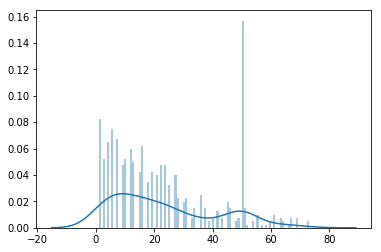

In [11]:
sns.distplot((test.groupby('patient_id')[['gender']].count()/30), bins=100)

In [12]:
temp = test.groupby('patient_id')[['gender']].count().reset_index()
temp[['gender']] = temp[['gender']]/30
temp.loc[temp.gender == 50].patient_id.values

array([  45,   88,  126,  131,  166,  249,  347,  461,  469,  473,  494,
        536,  606,  609,  673,  689,  715,  758,  761,  779,  815,  835,
        901,  965,  969,  975,  977,  980, 1026, 1197, 1221, 1264, 1306,
       1334, 1378, 1382, 1389, 1398, 1437, 1442, 1510, 1512, 1640, 1662,
       1665, 1796, 1841, 1917, 1968, 2000, 2001, 2124, 2308, 2358, 2359,
       2420, 2428, 2667, 2679, 2701, 2741, 2761, 2837])

In [15]:
test_50 = test.loc[test.patient_id.isin(temp.loc[temp.gender == 50].patient_id.values)]
test_other = test.loc[~test.index.isin(test_50.index)]
test_other.head()
test_50.head()

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,xx1,xx2,xx3,xx4,xx5
0,1005,1005-1,0,80,41,4,2,1,0,0,59.0,99.0,118.0,38.0,66.0
1,1005,1005-1,0,80,41,4,2,1,0,0,60.0,98.0,124.0,41.0,71.0
2,1005,1005-1,0,80,41,4,2,1,0,0,60.0,97.0,125.0,42.0,70.0
3,1005,1005-1,0,80,41,4,2,1,0,0,58.0,99.0,123.0,41.0,69.0
4,1005,1005-1,0,80,41,4,2,1,0,0,60.0,100.0,133.0,47.0,78.0


,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,xx1,xx2,xx3,xx4,xx5
1860,1026,1026-1,1,71,43,11,3,0,1,1,98.667,99.817,99.853,38.234,58.816
1861,1026,1026-1,1,71,43,11,3,0,1,1,98.900,100.000,96.869,38.067,57.831
1862,1026,1026-1,1,71,43,11,3,0,1,1,98.517,99.967,91.533,35.367,54.182
1863,1026,1026-1,1,71,43,11,3,0,1,1,98.400,99.817,91.501,35.851,54.629
1864,1026,1026-1,1,71,43,11,3,0,1,1,97.283,99.833,90.002,33.984,53.115


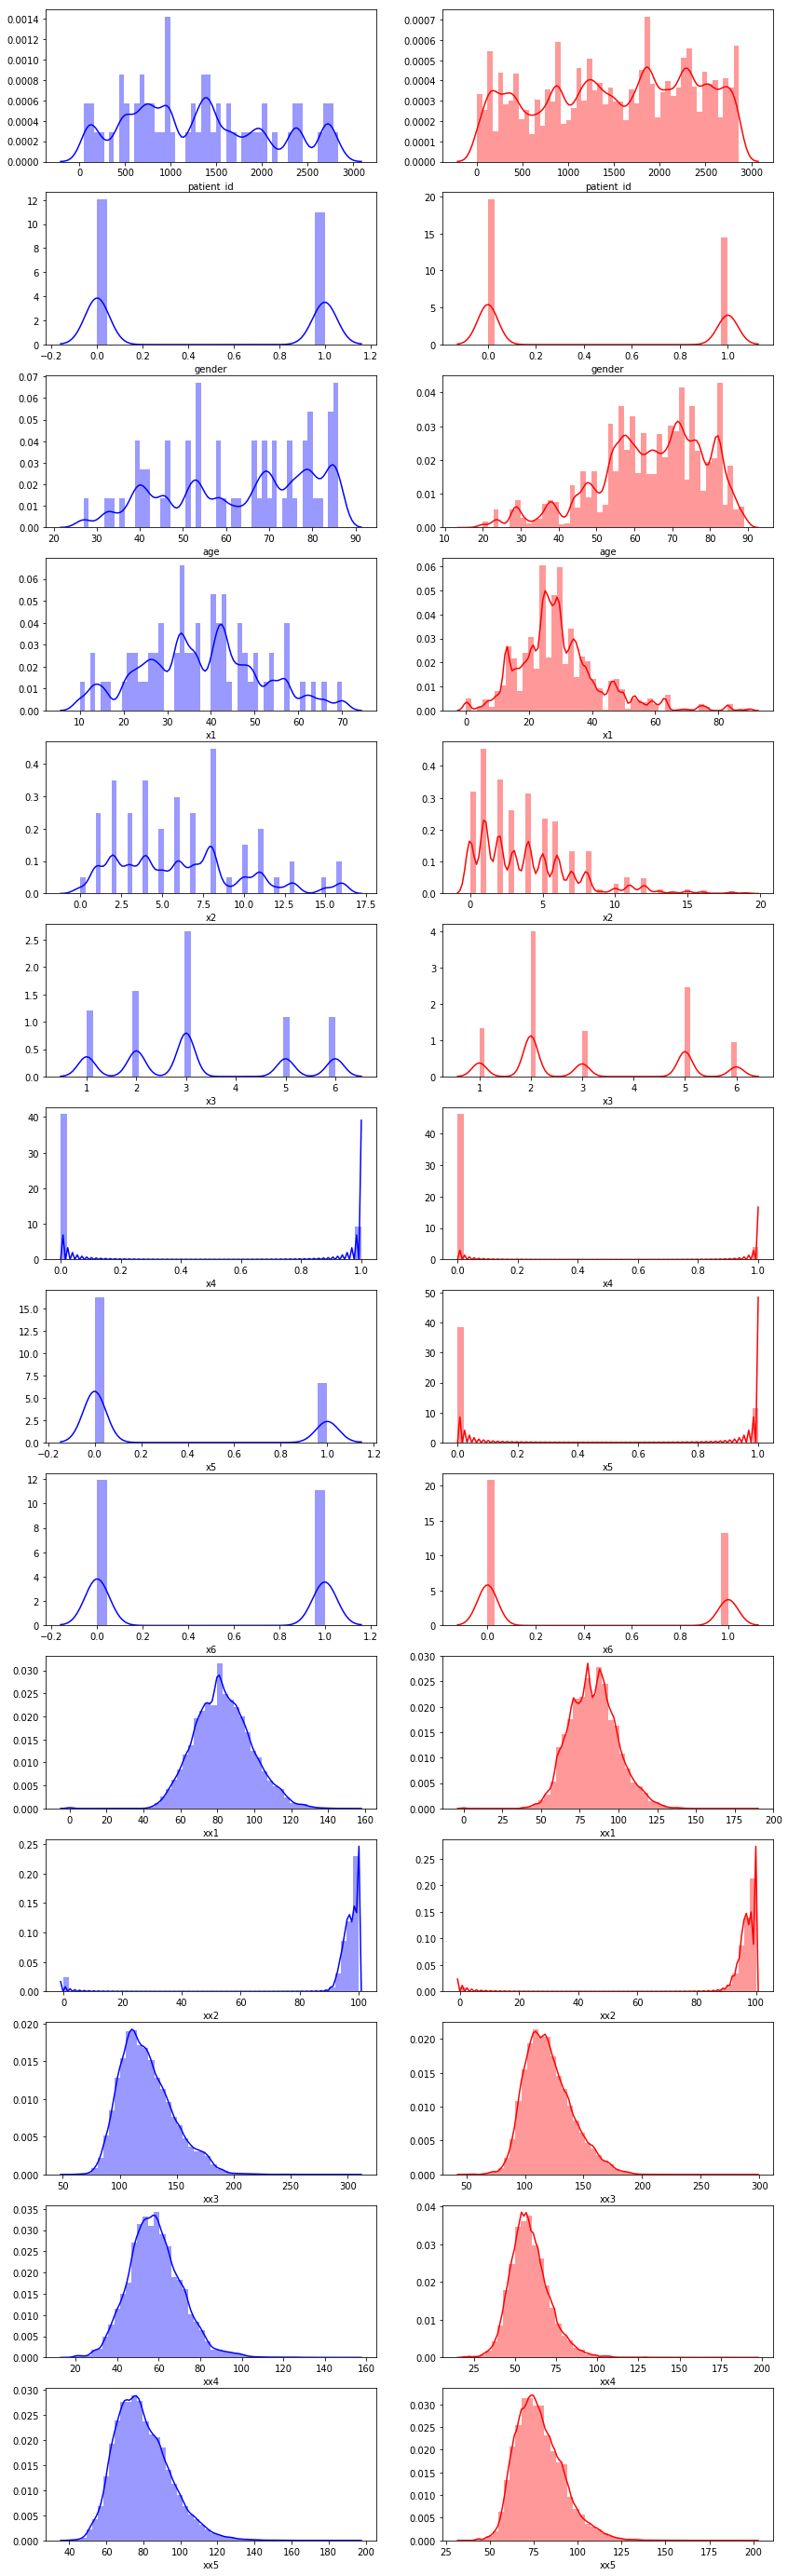

In [16]:
columns = list(test_other.columns)
columns.remove('key')

fig, ax = plt.subplots(nrows=len(columns), 
                       ncols=2, sharex=False, sharey=False, figsize=(14,50))
for i in range(len(columns)):
    sns.distplot(test_50[columns[i]].values, kde=True, color="b", 
                 ax=ax[i][0], axlabel = columns[i])
    sns.distplot(test_other[columns[i]].values, kde=True, color='r',
                 ax=ax[i][1], axlabel = columns[i])

plt.show()
# the distribution is almost the same

### Impute the xx2 which number is 0

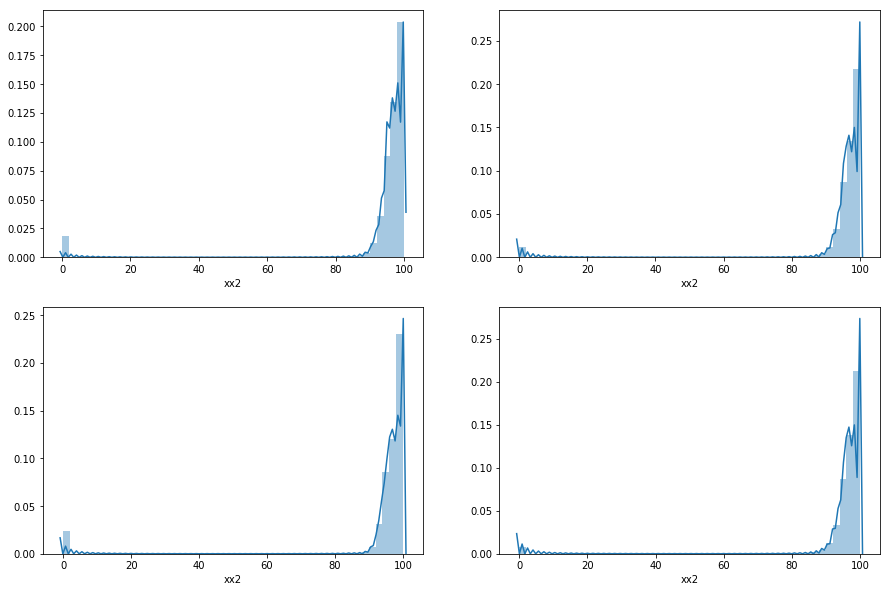

In [22]:
fig, ax = plt.subplots(nrows=2, 
                       ncols=2, sharex=False, sharey=False, figsize=(15,10))
sns.distplot(train.xx2, ax=ax[0][0])
sns.distplot(test.xx2, ax=ax[0][1])
sns.distplot(test_50.xx2, ax=ax[1][0])
sns.distplot(test_other.xx2, ax=ax[1][1])

In [33]:
train_key = train.key.unique()
train_list = []
test_key = test.key.unique()
test_list = []
# train_key
for key, df in train.groupby('key'):
    df.loc[df.key == key].xx2 = df.loc[df.key == key].xx2.replace(to_replace=0, method='bfill')
    train_list.append(df)
train_after_impute = pd.concat(train_list, axis=0)
    
for key, df in test.groupby('key'):
    df.loc[df.key == key].xx2 = df.loc[df.key == key].xx2.replace(to_replace=0, method='bfill')
    test_list.append(df)
test_after_impute = pd.concat(test_list, axis=0)

In [34]:
train_after_impute

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,xx1,xx2,xx3,xx4,xx5,y_mean_MAP,y_mean_HR
209160,0,0-28,0,72,39,5,1,0,0,0,82.0,100.0,124.0,69.0,89.0,86.426667,79.130000
209161,0,0-28,0,72,39,5,1,0,0,0,82.0,100.0,121.0,67.0,87.0,86.426667,79.130000
209162,0,0-28,0,72,39,5,1,0,0,0,81.0,100.0,118.0,66.0,85.0,86.426667,79.130000
209163,0,0-28,0,72,39,5,1,0,0,0,81.0,100.0,117.0,66.0,85.0,86.426667,79.130000
209164,0,0-28,0,72,39,5,1,0,0,0,81.0,100.0,116.0,67.0,85.0,86.426667,79.130000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894775,999,999-9,0,41,0,1,5,0,0,0,107.0,97.0,98.0,48.0,61.0,63.740000,108.843333
894776,999,999-9,0,41,0,1,5,0,0,0,109.0,98.0,102.0,51.0,64.0,63.740000,108.843333
894777,999,999-9,0,41,0,1,5,0,0,0,108.0,98.0,98.0,47.0,61.0,63.740000,108.843333
894778,999,999-9,0,41,0,1,5,0,0,0,108.0,97.0,96.0,47.0,60.0,63.740000,108.843333


#### x4, x5, x6 not vary.

In [41]:
len(train.patient_id.unique())
train[['patient_id', 'x3']].drop_duplicates().shape

2321

(2321, 2)

#### Concatenate the data for both train and test set

In [51]:
train_after_impute[['patient_id', 'key']].drop_duplicates().shape
train_after_impute[['patient_id', 'key', 'x4', 'x5', 'x6']].drop_duplicates().shape

(44923, 2)

(44923, 5)

In [53]:
temp1 = train_after_impute[['patient_id', 'key', 'gender', 'age', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']].drop_duplicates()

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6
209160,0,0-28,0,72,39,5,1,0,0,0
1258140,1,1-10,1,64,55,9,5,1,0,1
1258170,1,1-11,1,64,55,9,5,1,0,1
1258200,1,1-14,1,64,55,9,5,1,0,1
1258230,1,1-15,1,64,55,9,5,1,0,1
...,...,...,...,...,...,...,...,...,...,...
894990,999,999-21,0,41,0,1,5,0,0,0
894660,999,999-3,0,41,0,1,5,0,0,0
894690,999,999-5,0,41,0,1,5,0,0,0
894720,999,999-7,0,41,0,1,5,0,0,0


In [62]:
expand = train_after_impute[['xx1', 'xx2', 'xx3', 'xx4', 'xx5']]
expand_final = pd.DataFrame(expand.values.flatten().reshape(-1,150))
temp1 = train_after_impute[['patient_id', 'key', 'gender', 'age', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'y_mean_MAP', 'y_mean_HR']].\
drop_duplicates().reset_index().drop(columns = 'index')
train = pd.concat([temp1, expand_final], axis=1)
train.shape

(44923, 162)

In [64]:
expand = test_after_impute[['xx1', 'xx2', 'xx3', 'xx4', 'xx5']]
expand_final = pd.DataFrame(expand.values.flatten().reshape(-1,150))
temp1 = test_after_impute[['patient_id', 'key', 'gender', 'age', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']].\
drop_duplicates().reset_index().drop(columns = 'index')
test = pd.concat([temp1, expand_final], axis=1)
test.shape

(13019, 160)

### resample the data
for observation > 73 in the training set, desample it to be 50.

In [71]:
temp = train.groupby('patient_id')[['key']].count().reset_index()
temp.loc[temp.key > 73].patient_id

2          2
3          3
67        75
109      127
117      138
        ... 
2181    2710
2246    2792
2253    2799
2301    2858
2320    2878
Name: patient_id, Length: 100, dtype: int64

In [77]:
train_desample = train.loc[train.patient_id.isin(temp.loc[temp.key > 73].patient_id)]
train_original = train.loc[~train.patient_id.isin(temp.loc[temp.key > 73].patient_id)]
train_desample = train_desample.groupby('patient_id').apply(lambda x: x.sample(50)).droplevel(0)

In [79]:
train_after_sample = pd.concat([train_original, train_desample], axis=0)

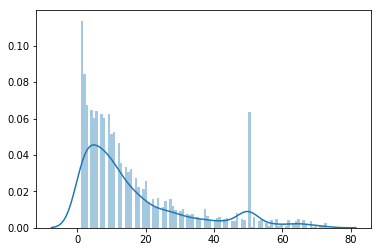

In [81]:
sns.distplot((train_after_sample.groupby('patient_id')[['gender']].count()), bins=100)

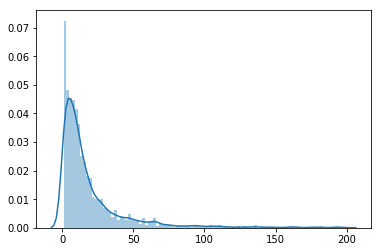

In [42]:
sns.distplot((train_after_impute.groupby('patient_id')[['gender']].count()/30), bins=100)

### Use train_after_sample to train the model
### lightgbm

In [98]:
test.drop(columns = 'y_mean_MAP', inplace=True)

In [99]:
import lightgbm as lgb

In [100]:
train_data = lgb.Dataset(train_after_sample.drop(columns = ['y_mean_MAP', 'y_mean_HR', 'key', 'patient_id']),
                         label = train_after_sample['y_mean_MAP'], 
                         categorical_feature=['x3', 'x4', 'x5', 'x6'])
model = lgb.train(params = {'metric': 'MSE'} ,train_set = train_data)
print(r2_score(model.predict(train_after_sample.drop(columns = ['y_mean_MAP', 'y_mean_HR', 'key', 'patient_id'])),
               train_after_sample[['y_mean_MAP']]))
# print(r2_score(model.predict(val.drop(columns = ['y_mean_MAP', 'y_mean_HR','log_y_mean_MAP','sqrt_y_mean_MAP',
#                                               'log_y_mean_HR', 'sqrt_y_mean_HR', 'key', 'patient_id', 'key_label'])), val[['y_mean_MAP']]))


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.9153886674675196


In [101]:
test['y_mean_MAP'] = model.predict(test.drop(columns=['key', 'patient_id']))

In [102]:
train_data = lgb.Dataset(train_after_sample.drop(columns = ['y_mean_MAP', 'y_mean_HR', 'key', 'patient_id']),
                         label = train_after_sample['y_mean_HR'], 
                         categorical_feature=['x3', 'x4', 'x5', 'x6'])
model = lgb.train(params = {'metric': 'MSE'} ,train_set = train_data)
print(r2_score(model.predict(train_after_sample.drop(columns = ['y_mean_MAP', 'y_mean_HR', 'key', 'patient_id'])),
               train_after_sample[['y_mean_HR']]))
# print(r2_score(model.predict(val.drop(columns = ['y_mean_MAP', 'y_mean_HR','log_y_mean_MAP','sqrt_y_mean_MAP',
#                                               'log_y_mean_HR', 'sqrt_y_mean_HR', 'key', 'patient_id', 'key_label'])), val[['y_mean_MAP']]))


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.9678538062867907


In [103]:
test['y_mean_HR'] = model.predict(test.drop(columns=['key', 'patient_id', 'y_mean_MAP']))

In [104]:
test

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,...,142,143,144,145,146,147,148,149,y_mean_MAP,y_mean_HR
0,1005,1005-1,0,80,41,4,2,1,0,0,...,110.0,35.0,60.0,55.0,99.0,116.0,36.0,61.0,64.388220,55.096798
1,1005,1005-10,0,80,41,4,2,0,0,0,...,129.0,48.0,72.0,71.0,100.0,124.0,46.0,68.0,70.564504,73.198180
2,1005,1005-11,0,80,41,4,2,1,0,0,...,102.0,46.0,63.0,65.0,89.0,105.0,46.0,62.0,64.508021,68.883274
3,1005,1005-12,0,80,41,4,2,1,0,0,...,97.0,40.0,58.0,68.0,97.0,108.0,47.0,68.0,69.146770,60.832938
4,1005,1005-13,0,80,41,4,2,0,0,0,...,135.0,54.0,77.0,76.0,99.0,132.0,52.0,76.0,77.098393,75.167815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13014,992,992-5,1,29,21,1,1,0,0,0,...,104.0,53.0,66.0,108.0,99.0,104.0,53.0,66.0,66.174538,107.611976
13015,992,992-6,1,29,21,1,1,0,0,0,...,104.0,53.0,66.0,108.0,99.0,104.0,53.0,66.0,66.174538,107.611976
13016,992,992-7,1,29,21,1,1,0,0,0,...,116.0,74.0,84.0,106.0,100.0,116.0,74.0,84.0,82.585718,105.607698
13017,992,992-8,1,29,21,1,1,0,0,0,...,116.0,74.0,84.0,104.0,99.0,116.0,74.0,84.0,84.480521,103.599451


In [108]:
sample = pd.read_csv('submit_oversample_log2.csv')
sample

,key,y_mean_MAP,y_mean_HR
0,1005-1,63.503256,54.939878
1,1005-2,62.778380,64.952136
2,1005-3,65.319156,74.656708
3,1005-4,78.467301,71.663162
4,1005-5,72.850996,78.051323
...,...,...,...
13014,992-12,69.398037,106.493589
13015,992-13,69.344835,108.680976
13016,992-14,83.199996,105.429742
13017,992-15,82.719331,104.383466


In [110]:
temp_final = test[['key', 'y_mean_MAP', 'y_mean_HR']]
temp_final.columns = ['key', 'map', 'hr']
final = pd.merge(sample, temp_final, on ='key', how='left')

In [114]:
final = final[['key', 'map', 'hr']]
final.columns = ['key', 'y_mean_MAP', 'y_mean_HR']
final

,key,y_mean_MAP,y_mean_HR
0,1005-1,64.388220,55.096798
1,1005-2,63.364453,65.005140
2,1005-3,66.425899,72.779631
3,1005-4,78.415594,72.489899
4,1005-5,71.217796,78.025758
...,...,...,...
13014,992-12,69.295233,106.480346
13015,992-13,68.159622,108.673027
13016,992-14,82.585718,105.607698
13017,992-15,83.071119,104.189743


In [115]:
final.to_csv('final.csv', index=False)

In [117]:
test = test.drop(columns = ['y_mean_MAP', 'y_mean_HR'])
test

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,...,140,141,142,143,144,145,146,147,148,149
0,1005,1005-1,0,80,41,4,2,1,0,0,...,53.0,98.0,110.0,35.0,60.0,55.0,99.0,116.0,36.0,61.0
1,1005,1005-10,0,80,41,4,2,0,0,0,...,71.0,97.0,129.0,48.0,72.0,71.0,100.0,124.0,46.0,68.0
2,1005,1005-11,0,80,41,4,2,1,0,0,...,65.0,90.0,102.0,46.0,63.0,65.0,89.0,105.0,46.0,62.0
3,1005,1005-12,0,80,41,4,2,1,0,0,...,57.0,96.0,97.0,40.0,58.0,68.0,97.0,108.0,47.0,68.0
4,1005,1005-13,0,80,41,4,2,0,0,0,...,75.0,99.0,135.0,54.0,77.0,76.0,99.0,132.0,52.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13014,992,992-5,1,29,21,1,1,0,0,0,...,107.0,100.0,104.0,53.0,66.0,108.0,99.0,104.0,53.0,66.0
13015,992,992-6,1,29,21,1,1,0,0,0,...,107.0,100.0,104.0,53.0,66.0,108.0,99.0,104.0,53.0,66.0
13016,992,992-7,1,29,21,1,1,0,0,0,...,106.0,100.0,116.0,74.0,84.0,106.0,100.0,116.0,74.0,84.0
13017,992,992-8,1,29,21,1,1,0,0,0,...,103.0,99.0,116.0,74.0,84.0,104.0,99.0,116.0,74.0,84.0


In [118]:
train_after_sample

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,...,140,141,142,143,144,145,146,147,148,149
0,0,0-28,0,72,39,5,1,0,0,0,...,82.0,100.0,113.0,75.0,91.0,79.0,100.0,112.0,71.0,88.0
1,1,1-10,1,64,55,9,5,1,0,1,...,72.0,99.0,108.0,58.0,73.0,71.0,100.0,109.0,58.0,73.0
2,1,1-11,1,64,55,9,5,1,0,1,...,71.0,100.0,119.0,61.0,77.0,73.0,100.0,117.0,61.0,77.0
3,1,1-14,1,64,55,9,5,1,0,1,...,128.0,100.0,115.0,71.0,82.0,119.0,100.0,116.0,70.0,82.0
4,1,1-15,1,64,55,9,5,1,0,1,...,188.0,100.0,149.0,91.0,106.0,190.0,100.0,133.0,85.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33258,2878,2878-30,0,74,30,3,5,0,0,0,...,90.0,100.0,138.0,56.0,84.0,89.0,99.0,130.0,54.0,80.0
33272,2878,2878-44,0,74,30,3,5,0,0,0,...,88.0,98.0,147.0,54.0,86.0,89.0,99.0,149.0,55.0,87.0
33224,2878,2878-125,0,74,30,3,5,0,0,0,...,68.0,100.0,119.0,40.0,64.0,70.0,100.0,119.0,41.0,64.0
33284,2878,2878-65,0,74,30,3,5,0,0,0,...,92.0,93.0,152.0,61.0,93.0,93.0,92.0,155.0,61.0,94.0


### RF

In [119]:
from sklearn.ensemble import RandomForestRegressor
rf_MAP = RandomForestRegressor(n_estimators=100, max_depth=20, 
                               min_samples_split=40, min_samples_leaf=20)

In [121]:
rf_MAP.fit(train_after_sample.drop(columns = ['y_mean_MAP', 'y_mean_HR', 'patient_id', 'key']),
           train_after_sample.y_mean_MAP)
rf_MAP.predict(test.drop(columns = ['patient_id', 'key']))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=40,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

array([63.43270818, 71.85612564, 65.30458917, ..., 82.36641912,
       84.79962584, 69.09259601])

In [122]:
MAP = rf_MAP.predict(test.drop(columns = ['patient_id', 'key']))

In [123]:
rf_HR = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=40, min_samples_leaf=20)
rf_HR.fit(train_after_sample.drop(columns = ['y_mean_MAP', 'y_mean_HR', 'patient_id', 'key']),
           train_after_sample.y_mean_HR)
rf_HR.predict(test.drop(columns = ['patient_id', 'key']))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=40,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

array([ 55.15221948,  74.19609345,  65.2601817 , ..., 105.42748847,
       103.71813491, 111.98284013])

In [124]:
HR = rf_HR.predict(test.drop(columns = ['patient_id', 'key']))

In [126]:
test['MAP'] = MAP
test['HR'] = HR
final2 = pd.merge(sample, test[['key', 'MAP', 'HR']], on='key', how='left')
final2 = final2[['key', 'MAP', 'HR']]
final2.columns = ['key', 'y_mean_MAP', 'y_mean_HR']
final2

,key,y_mean_MAP,y_mean_HR
0,1005-1,63.432708,55.152219
1,1005-2,63.780220,65.168692
2,1005-3,65.708332,73.168955
3,1005-4,79.129758,72.376091
4,1005-5,72.646205,78.513838
...,...,...,...
13014,992-12,69.573081,106.694979
13015,992-13,68.274268,108.895084
13016,992-14,82.366419,105.427488
13017,992-15,82.749608,104.078751


In [127]:
final2.to_csv('final2.csv', index=False)